# 構造式の自動描画・保存・Excel出力

このノートブックは、ChemDrawを使わずにPythonとRDKitを用いて化学構造式の描画、PNG保存、Excelへのエクスポートまでを自動化するワークフローです。

In [1]:
# 必要なライブラリのインストール（初回のみ）
!pip install rdkit pubchempy XlsxWriter > /dev/null

In [2]:
import io
import os
from typing import Dict, List, Optional, Tuple


import pandas as pd
from PIL import Image
import pubchempy as pcp


from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [3]:
def get_smiles_dict_from_names(
    compound_names: List[str],
    max_results_per_name: int = 10
) -> Dict[str, List[str]]:
    """
    化合物名のリストから、それぞれに対応するSMILES文字列を取得し、辞書形式で返す。

    Args:
        compound_names (List[str]): 化合物名のリスト。
        max_results_per_name (int): 各化合物名ごとの最大取得件数。デフォルトは10。

    Returns:
        Dict[str, List[str]]: 化合物名をキー、対応するSMILES文字列のリストを値とする辞書。
    """
    smiles_dict = {}

    for name in compound_names:
        compounds = pcp.get_compounds(name, 'name')
        if not compounds:
            print(f"[警告] 化合物が見つかりませんでした: {name}")
            smiles_dict[name] = []
        else:
            smiles_list = [
                cmpd.isomeric_smiles
                for cmpd in compounds[:max_results_per_name]
                if cmpd.isomeric_smiles
            ]
            smiles_dict[name] = smiles_list

    return smiles_dict

In [4]:
# SMILESを取得したい化合物名のリストを定義
compound_names = ['Aspirin', 'Lidocaine', 'Ibuprofen']

smiles_dict = get_smiles_dict_from_names(compound_names)

for name, smiles_list in smiles_dict.items():
    print(f"{name}:")
    for smi in smiles_list:
        print(f"  - {smi}")

Aspirin:
  - CC(=O)OC1=CC=CC=C1C(=O)O
Lidocaine:
  - CCN(CC)CC(=O)NC1=C(C=CC=C1C)C
Ibuprofen:
  - CC(C)CC1=CC=C(C=C1)C(C)C(=O)O


In [5]:
def draw_molecule_grids_from_dict(
    smiles_dict: Dict[str, List[str]],
    mols_per_row: int = 3,
    sub_img_size: tuple = (250, 250)
) -> Dict[str, Optional[Image.Image]]:
    """
    化合物名をキー、SMILESリストを値とする辞書から、各化合物の構造式グリッド画像を作成する。

    Args:
        smiles_dict (Dict[str, List[str]]): 化合物名とそのSMILESリストの辞書。
        mols_per_row (int): 1行あたりに表示する構造式の数。
        sub_img_size (tuple): 各構造式画像のサイズ（幅, 高さ）。

    Returns:
        Dict[str, PIL.Image.Image or None]: 各化合物名ごとに描画された画像オブジェクトを返す辞書。
    """
    result_images = {}

    for compound_name, smiles_list in smiles_dict.items():
        mols = []
        for smi in smiles_list:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                mols.append(mol)

        if not mols:
            print(f"[警告] 有効な分子が存在しません: {compound_name}")
            result_images[compound_name] = None
            continue

        img = Draw.MolsToImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size)
        result_images[compound_name] = img

    return result_images


== Aspirin ==


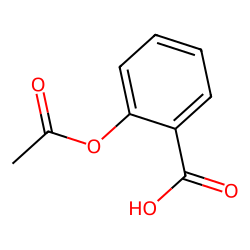

== Lidocaine ==


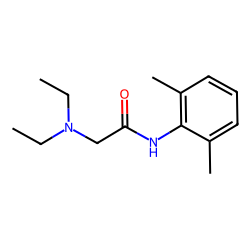

== Ibuprofen ==


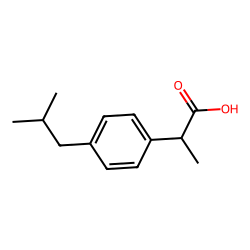

In [6]:
# 各化合物の構造式をグリッド画像として描画
grid_imgs = draw_molecule_grids_from_dict(smiles_dict)

# 名前と対応する構造を表示
for name, img in grid_imgs.items():
    if img:
        print(f"== {name} ==")
        display(img)

In [7]:
def save_molecule_images_from_dict(
    smiles_dict: Dict[str, List[str]],
    output_dir: str = "./output",
    image_size: Tuple[int, int] = (300, 300)
) -> None:
    """
    化合物名ごとのSMILESリストから構造式画像を生成し、個別のPNGファイルとして保存する。

    Args:
        smiles_dict (Dict[str, List[str]]): 化合物名をキー、SMILESのリストを値とする辞書。
        output_dir (str, optional): 出力画像のベースディレクトリ。デフォルトは'./output'。
        image_size (Tuple[int, int], optional): 出力画像のサイズ（幅, 高さ）。デフォルトは(300, 300)。

    Returns:
        None
    """
    # 出力ディレクトリを作成（なければ）
    os.makedirs(output_dir, exist_ok=True)

    for compound_name, smiles_list in smiles_dict.items():
        if not smiles_list:
            print(f"[警告] SMILESが見つかりませんでした: {compound_name}")
            continue

        for i, smi in enumerate(smiles_list):
            mol = Chem.MolFromSmiles(smi)
            if mol:
                img = Draw.MolToImage(mol, size=image_size)

                # ファイル名：output/compound_name_1.png など
                filename = f"{compound_name}_{i+1}.png"
                save_path = os.path.join(output_dir, filename)

                img.save(save_path)
            else:
                print(f"[警告] 無効なSMILESをスキップしました ({compound_name}): {smi}")


In [8]:
# 構造式を個別のPNGファイルとして保存
save_molecule_images_from_dict(smiles_dict, output_dir="./images")

In [9]:
def generate_dataframe_from_dict_and_export_excel(
    smiles_dict: Dict[str, List[str]],
    output_excel_path: str = "output/structure_table.xlsx"
) -> pd.DataFrame:
    """
    化合物名とSMILESリストの辞書から構造式付きDataFrameを生成し、Excelファイルとして保存する。

    Args:
        smiles_dict (Dict[str, List[str]]): 化合物名をキー、SMILES文字列のリストを値とする辞書。
        output_excel_path (str, optional): 出力先のExcelファイルパス。デフォルトは 'output/structure_table.xlsx'。

    Returns:
        pd.DataFrame: 'Name', 'SMILES', 'ROMol'列を含む構造式付きDataFrame。
    """
    # 出力先ディレクトリがなければ作成
    os.makedirs(os.path.dirname(output_excel_path), exist_ok=True)

    # 各化合物名とSMILESのペアをリスト化
    records = []
    for name, smiles_list in smiles_dict.items():
        for smi in smiles_list:
            if smi:  # Noneや空文字をスキップ
                records.append({'Name': name, 'SMILES': smi})

    # データフレーム作成
    df = pd.DataFrame(records)

    # 構造式列の追加
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES')

    # Excelファイルとして保存（構造式も画像として埋め込まれる）
    PandasTools.SaveXlsxFromFrame(df, output_excel_path, molCol='ROMol')

    print(f"[完了] 構造式付きExcelを保存しました → {output_excel_path}")
    return df

[完了] 構造式付きExcelを保存しました → output/chem_structures.xlsx


,Name,SMILES,ROMol
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,
1,Lidocaine,CCN(CC)CC(=O)NC1=C(C=CC=C1C)C,
2,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,

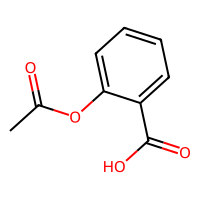
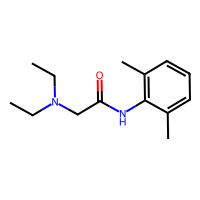
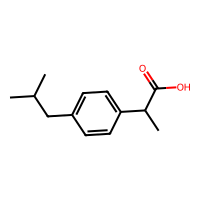

In [10]:
# 構造式を個別のPNGファイルとして保存
df = generate_dataframe_from_dict_and_export_excel(smiles_dict, output_excel_path="output/chem_structures.xlsx")
df